# ✅ FMCG Sales Forecasting (2022–2024) – Exploratory Business Insights  
### Focus SKU: `MI-006` (Milk Category)

This notebook presents a comprehensive exploratory analysis of a single product SKU (`MI-006`) using synthetic FMCG sales data from 2022 to 2024.

> The entire notebook is built with **reusable functions**, making it easy to extend to other SKUs, categories, or channels.

---

### What You’ll Find Here

- Clean calendar-based feature engineering  
- Stock availability and stockout pattern detection  
- Promotion effectiveness across channels and lifecycle phases  
- Sales trends, momentum, and seasonality decomposition  
- Business insights structured by **product lifecycle stage**

---

> ⚠️ _Note: This is a synthetic dataset. In real-life FMCG environments, delivery delays, promotions, and stockouts usually show stronger and more correlated effects._


## ✅ 1. Load & Quick Data Overview

>We begin by loading the main daily-level transactional dataset.  
>The data contains synthetic sales transactions for multiple SKUs across different channels and regions between 2022 and 2024.
>For this analysis, we focus on a single SKU — `MI-006` (Milk category) — using parameterized functions that can be reused across other SKUs.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

# Plotting style
plt.style.use("seaborn-whitegrid")
sns.set_palette("muted")

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_13/1286595602.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/fmcg-daily-sales-data-to-2022-2024/FMCG_2022_2024.csv")
df["date"] = pd.to_datetime(df["date"])

df.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


## ➜ Quick Data Overview

In [3]:
df.columns

Index(['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region',
       'pack_type', 'price_unit', 'promotion_flag', 'delivery_days',
       'stock_available', 'delivered_qty', 'units_sold'],
      dtype='object')

In [4]:
# Shape
print(f"Dataset shape: {df.shape}")

# Nulls
print("\nMissing values:")
display(df.isnull().sum())

# Info
print("\nData types and non-null counts:")
df.info()

# Unique values per column
print("\nUnique values per column:")
display(df.nunique().sort_values(ascending=False))

# Sample rows
print("\nRandom sample:")
display(df.sample(5, random_state=42))

Dataset shape: (190757, 14)

Missing values:


date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             190757 non-null  datetime64[ns]
 1   sku              190757 non-null  object        
 2   brand            190757 non-null  object        
 3   segment          190757 non-null  object        
 4   category         190757 non-null  object        
 5   channel          190757 non-null  object        
 6   region           190757 non-null  object        
 7   pack_type        190757 non-null  object        
 8   price_unit       190757 non-null  float64       
 9   promotion_flag   190757 non-null  int64         
 10  delivery_days    190757 non-null  int64         
 11  stock_available  190757 non-null  int64         
 12  delivered_qty    190757 non-null  int64         
 13  units_sold       190757 non-null  int64  

date               1076
price_unit          751
stock_available     355
delivered_qty       321
units_sold          135
sku                  30
brand                14
segment              13
category              5
delivery_days         5
channel               3
region                3
pack_type             3
promotion_flag        2
dtype: int64


Random sample:


,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
34724,2023-02-03,RE-025,ReBrand2,ReadyMeal-Seg3,ReadyMeal,E-commerce,PL-North,Multipack,3.09,0,1,160,149,31
40651,2023-03-10,YO-003,YoBrand1,Yogurt-Seg3,Yogurt,Retail,PL-North,Single,3.54,1,5,126,192,54
105272,2023-12-25,MI-011,MiBrand1,Milk-Seg2,Milk,E-commerce,PL-North,Multipack,3.91,0,1,180,213,17
41903,2023-03-16,MI-026,MiBrand4,Milk-Seg2,Milk,E-commerce,PL-South,Single,8.01,0,3,154,213,14
89803,2023-10-18,YO-024,YoBrand2,Yogurt-Seg3,Yogurt,Discount,PL-South,Multipack,5.65,0,5,230,196,22


In [5]:
# Time range
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")

Date range: 2022-01-21 → 2024-12-31


## ➜ Data sanity check

In [6]:
# checking the continuity of dates
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
missing_dates = date_range.difference(df['date'].dropna().unique())

print("Number of missing dates:", len(missing_dates))
print("Missing dates:", missing_dates)

Number of missing dates: 0
Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [7]:
# Get all unique dates and SKUs
all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
all_skus = df['sku'].unique()

# Create a full date × SKU grid
full_grid = pd.DataFrame([(date, sku) for date in all_dates for sku in all_skus], columns=['date', 'sku'])

# Get existing (date, SKU) combinations
existing = df[['date', 'sku']].drop_duplicates()

# Merge and find missing combinations
merged = full_grid.merge(existing, on=['date', 'sku'], how='left', indicator=True)
missing = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

# Result
print(f"Missing (date, SKU) combinations: {len(missing)}")
display(missing.head(10))


Missing (date, SKU) combinations: 7335


,date,sku
1,2022-01-21,MI-026
2,2022-01-21,YO-029
3,2022-01-21,YO-005
4,2022-01-21,YO-012
5,2022-01-21,YO-014
6,2022-01-21,YO-001
7,2022-01-21,RE-004
8,2022-01-21,RE-007
9,2022-01-21,RE-015
10,2022-01-21,MI-023


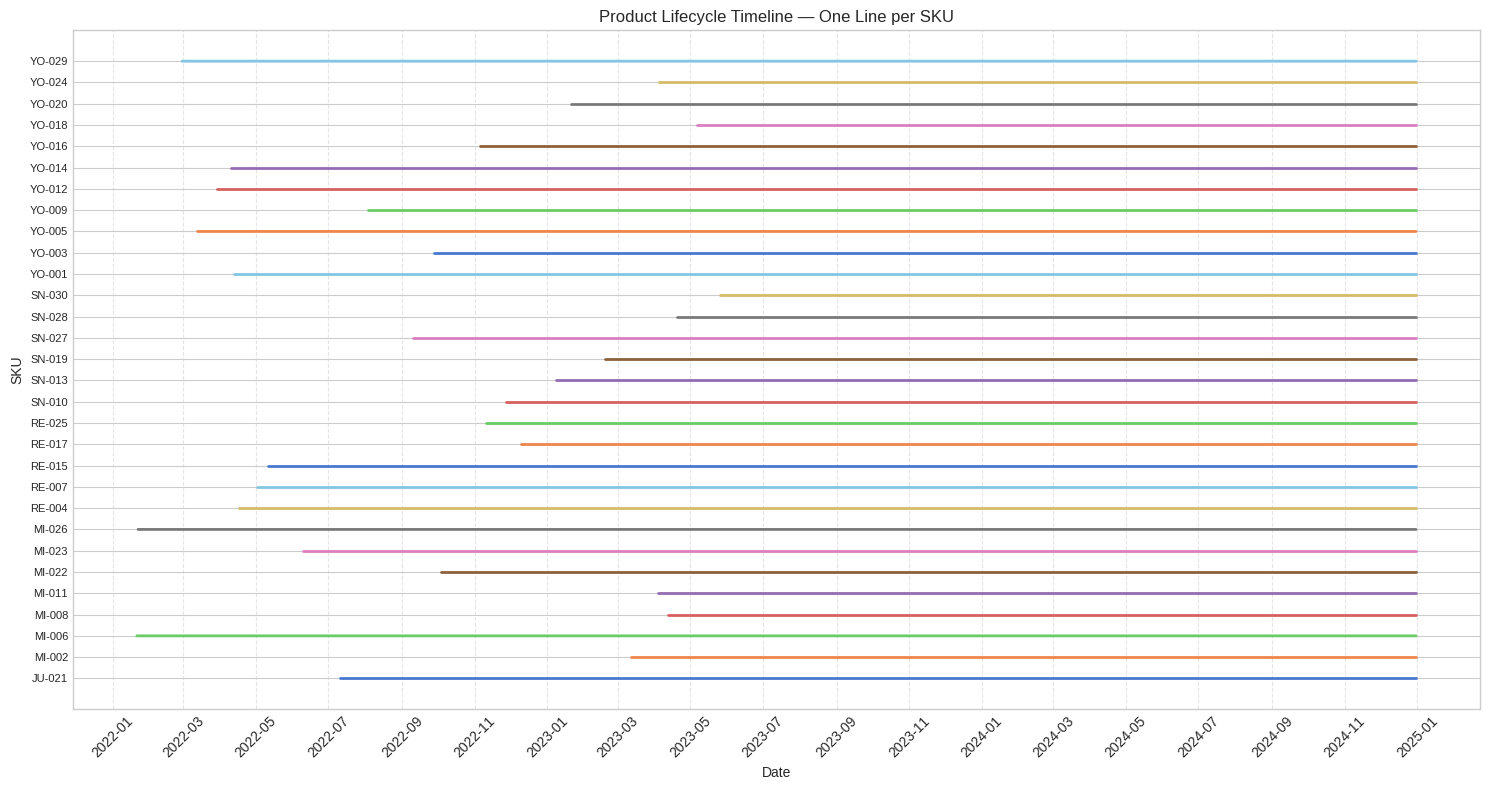

In [8]:
# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Get list of unique SKUs
skus = df['sku'].unique()

# Set up plot size dynamically based on number of SKUs
plt.figure(figsize=(15, len(skus) * 0.2 + 2))

# Plot a horizontal line per SKU showing active dates
for i, sku in enumerate(sorted(skus)):
    dates_for_sku = df[df['sku'] == sku]['date'].sort_values().unique()
    plt.plot(dates_for_sku, [i] * len(dates_for_sku), lw=2)

# Formatting
plt.yticks(range(len(skus)), sorted(skus), fontsize=8)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("SKU")
plt.title("Product Lifecycle Timeline — One Line per SKU")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


>The timeline visualization reveals clear patterns in SKU availability over time. Some products have continuous presence throughout the dataset, while others exhibit shorter or intermittent lifecycles. These gaps often reflect the natural introduction or discontinuation of products rather than missing data.
>This observation is crucial for accurate modeling. It suggests that imputation strategies (e.g., filling missing sales with zeros) should be applied only within each product’s active period to avoid introducing artificial demand for products that were not available in the market.
>
>By aligning data preprocessing with product lifecycle logic, we ensure more realistic forecasts and better business decisions.

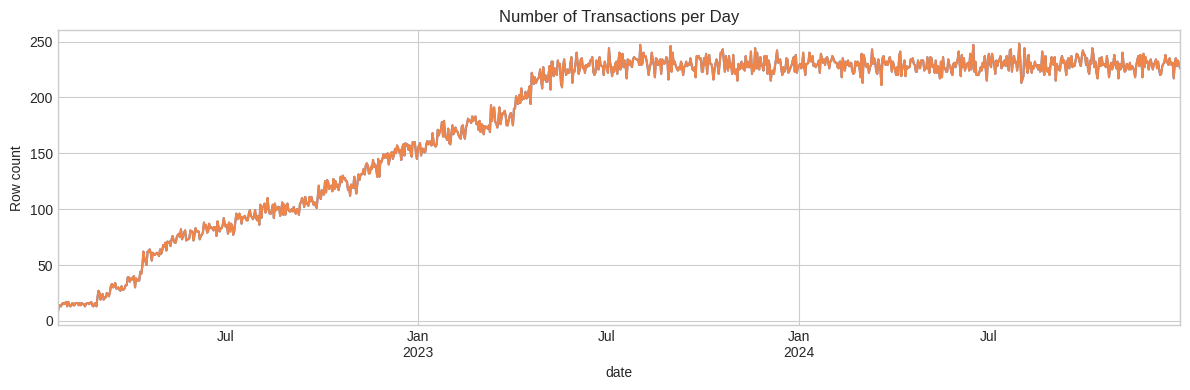

In [9]:
# Check number of records per day
daily_counts = df.groupby("date").size()

# Plot number of records per day
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
daily_counts.plot()
plt.title("Number of Transactions per Day")
plt.ylabel("Row count")
plt.xlabel("Date")
plt.tight_layout()
#plt.show()
daily_counts.plot();

## ✅ 2. Calendar Feature Engineering

To capture seasonal and temporal patterns in demand, we enrich the dataset with calendar-based features using a reusable function.

The function `add_calendar_features()` adds the following features at the daily level:
- **Day of week** (0 = Monday, ..., 6 = Sunday)
- **Weekend flag**
- **Month, quarter, year**
- **Start/end of month**
- **Start/end of quarter**
- **Week start date** (`week`) and ISO **week number**
- **Meteorological season** (Winter, Spring, Summer, Autumn)

Additionally, we manually flag selected **holiday peak shopping days**:
- Christmas (Dec 22–24)
- Easter (Apr 5–7)
- All Saints (Oct 30–31)
- May Holiday (Apr 30–May 2)
- New Year's Eve (Dec 30–31)

These flags help capture **short-term demand spikes** often seen in FMCG.


In [10]:
def add_calendar_features(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    """
    Adds standard calendar-based features to a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime column.
        date_col (str): Name of the datetime column (default: 'date').

    Returns:
        pd.DataFrame: DataFrame with enriched calendar features.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Basic calendar breakdown
    df["day_of_week"] = df[date_col].dt.dayofweek
    df["is_weekend"] = df["day_of_week"].isin([5, 6])
    df["month"] = df[date_col].dt.month
    df["year"] = df[date_col].dt.year
    df["quarter"] = df[date_col].dt.quarter
    df["is_start_of_month"] = df[date_col].dt.is_month_start
    df["is_end_of_month"] = df[date_col].dt.is_month_end
    df["is_quarter_start"] = df[date_col].dt.is_quarter_start
    df["is_quarter_end"] = df[date_col].dt.is_quarter_end

    # Week start (Monday) and ISO week number
    df["week"] = df[date_col] - pd.to_timedelta(df[date_col].dt.weekday, unit='D')
    df["week_number"] = df["week"].dt.isocalendar().week

    # Map month to meteorological seasons
    month_to_season = {
        12: "winter", 1: "winter", 2: "winter",
        3: "spring", 4: "spring", 5: "spring",
        6: "summer", 7: "summer", 8: "summer",
        9: "autumn", 10: "autumn", 11: "autumn"
    }
    df["season"] = df["month"].map(month_to_season)
    return df

# Apply function
df = add_calendar_features(df, date_col="date")

# Define manual holiday peak days (fixed month-day combinations)
holiday_dates = {
    "Christmas": ["12-22", "12-23", "12-24"],
    "Easter": ["04-05", "04-06", "04-07"],
    "All Saints": ["10-30", "10-31"],
    "May Weekend": ["04-30", "05-01", "05-02"],
    "New Year's Eve": ["12-30", "12-31"]
}

# Flatten all holiday date strings
flat_dates = sum(holiday_dates.values(), [])

# Expand to full date strings for all years in the dataset
holiday_peak = [f"{year}-{d}" for year in df["year"].unique() for d in flat_dates]

# Flag holiday peaks
df["date_str"] = df["date"].dt.strftime("%Y-%m-%d")
df["is_holiday_peak"] = df["date_str"].isin(holiday_peak)
df.drop("date_str", axis=1, inplace=True)


In [11]:
df.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,...,year,quarter,is_start_of_month,is_end_of_month,is_quarter_start,is_quarter_end,week,week_number,season,is_holiday_peak
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,...,2022,1,False,False,False,False,2022-01-17,3,winter,False
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,...,2022,1,False,False,False,False,2022-01-17,3,winter,False
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,...,2022,1,False,False,False,False,2022-01-17,3,winter,False
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,...,2022,1,False,False,False,False,2022-01-17,3,winter,False
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,...,2022,1,False,False,False,False,2022-01-17,3,winter,False


## ➜ Weekly Aggregation for Time Series Analysis

### Weekly Aggregation for Time Series Analysis

Most time-series analyses in this notebook are conducted on **weekly granularity**, rather than daily.

We aggregate the dataset by:
- `week` (starting Monday)
- `sku`

This allows us to analyze:
- Long-term trends
- Promotion and lifecycle patterns
- Seasonality and momentum


In [12]:
# Create weekly-level dataset: aggregate by SKU, week, channel, and region
weekly_df = (
    df.groupby(["sku", "week", "channel", "region"])
    .agg({
        "units_sold": "sum",
        "stock_available": "mean",
        "promotion_flag": "max",
        "price_unit": "mean",
        "delivery_days": "mean",
        "is_holiday_peak": "max"
    })
    .reset_index()
)


In [13]:
# Week (1–52)
weekly_df["week_number"] = weekly_df["week"].dt.isocalendar().week

# Month and year
weekly_df["month"] = weekly_df["week"].dt.month
weekly_df["year"] = weekly_df["week"].dt.year

# Holiday Flag – checks if the week contains a holiday (from original df)
holiday_weeks = df[df["is_holiday_peak"] == 1]["week"].unique()
weekly_df["is_holiday_week"] = weekly_df["week"].isin(holiday_weeks).astype(int)

# Simple Seasonal Flags
weekly_df["is_summer"] = weekly_df["month"].isin([6, 7, 8]).astype(int)
weekly_df["is_winter"] = weekly_df["month"].isin([12, 1, 2]).astype(int)

## ✅ 3. Daily Transaction Volume – SKU Presence Check


### Daily Transaction Volume – SKU Presence Check

We plot the daily number of transactions for SKU `MI-006` to verify:

- Data density and continuity
- Any gaps or low-activity periods
- Seasonality in data collection

A 7-day moving average helps smooth out weekly fluctuations.


> To better observe the overall trend and reduce daily noise, we applied a 7-day moving average. This helps highlight longer-term changes in transaction volume and makes seasonal patterns easier to detect.


In [14]:
def plot_daily_transactions_for_sku(df, sku):
    """
    Plots the number of daily transactions for a given SKU,
    including a 7-day moving average.
    """
    df_sku = df[df['sku'] == sku].copy()
    daily_counts = df_sku.groupby("date").size()
    smoothed = daily_counts.rolling(window=7).mean()

    plt.figure(figsize=(12, 4))
    daily_counts.plot(alpha=0.3, label="Daily Count")
    smoothed.plot(label="7-day Moving Average", linewidth=2)
    plt.title(f"Daily Transaction Volume (Smoothed) — SKU: {sku}")
    plt.ylabel("Transaction Count")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()


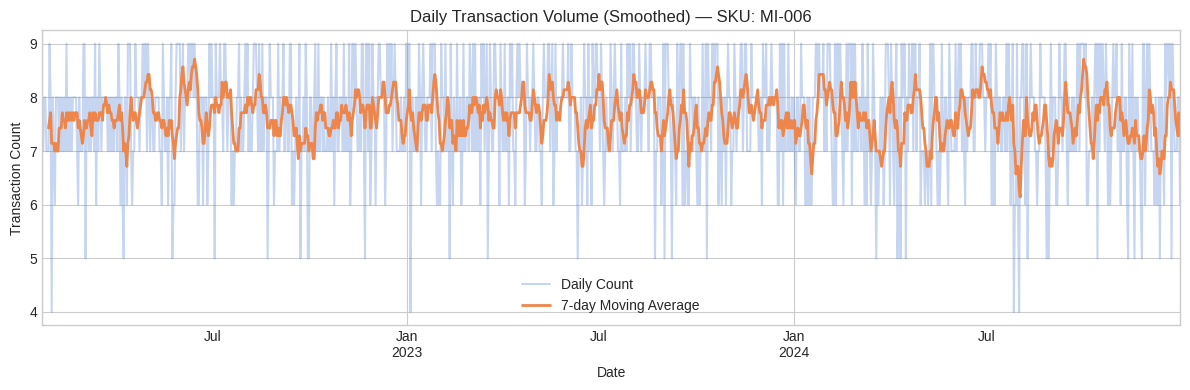

In [15]:
plot_daily_transactions_for_sku(df, sku="MI-006")


## ✅ 4. Decomposition of Weekly Demand

## Decomposition of Weekly Demand – SKU: MI-006

To better understand the sales behavior of SKU `MI-006`, we use a **multiplicative seasonal decomposition** on its weekly sales time series.

The decomposition isolates:
- **Trend**: Long-term direction (e.g. product maturity or decline)
- **Seasonality**: Weekly demand cycles
- **Residual**: Irregular fluctuations (e.g. stockouts, anomalies)

We use a reusable function `decompose_weekly_sales()` to perform this breakdown.  
This makes the logic easy to apply across other SKUs in future use cases.


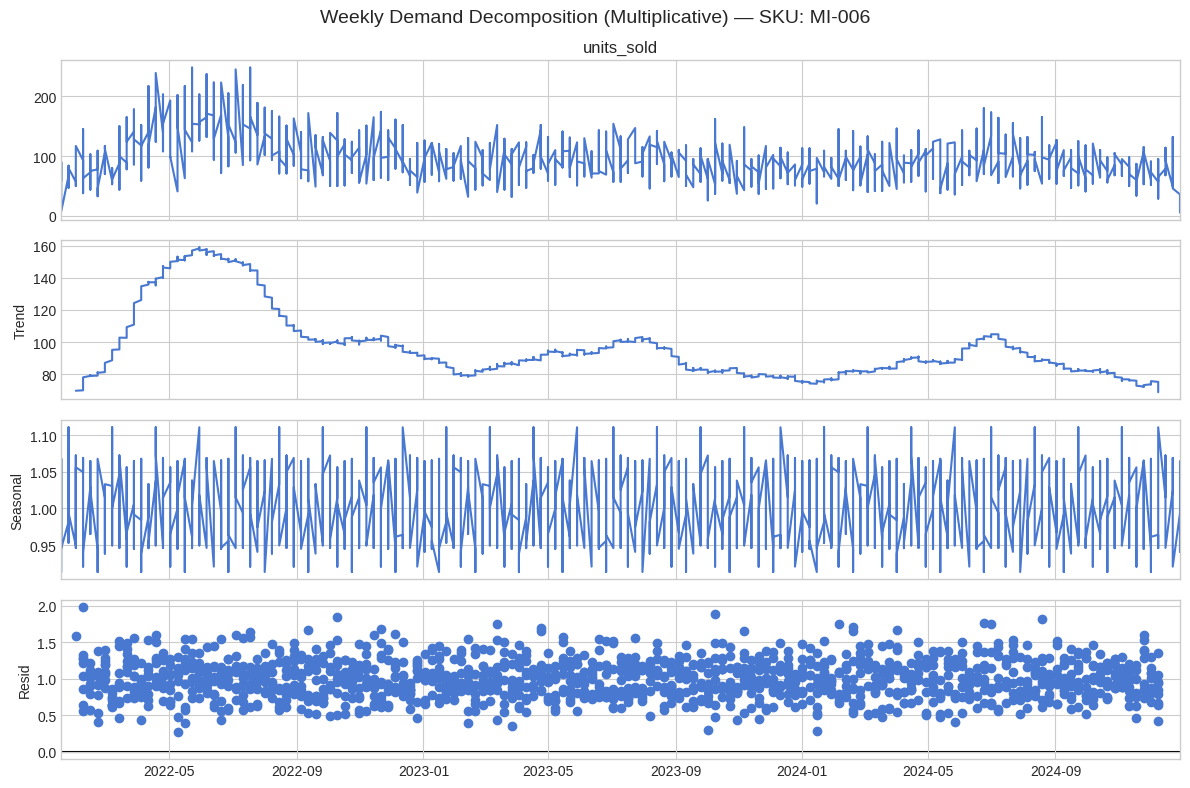

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def decompose_weekly_sales(df, sku):
    """
    Performs multiplicative seasonal decomposition on weekly sales for a given SKU.

    Parameters:
        df (pd.DataFrame): Weekly-level DataFrame with ['week', 'sku', 'units_sold']
        sku (str): The SKU identifier to analyze

    Output:
        Seasonal decomposition plot (trend, seasonal, residual)
    """
    df_sku = df[df["sku"] == sku].copy()
    series = df_sku.set_index("week")["units_sold"]
    series.index = pd.to_datetime(series.index)

    result = seasonal_decompose(series, model='multiplicative', period=52)

    fig = result.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"Weekly Demand Decomposition (Multiplicative) — SKU: {sku}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run decomposition for selected SKU on weekly data
decompose_weekly_sales(weekly_df, sku="MI-006")



- **Trend**: Demand rose significantly in early 2022, peaking around mid-year, followed by a gradual decline and stabilization. This likely reflects either product launch effects or seasonal market saturation.

- **Seasonality**: A clear **weekly seasonal pattern** is visible, repeating consistently across the entire period. This may correspond to retail cycles (e.g. weekend shopping behavior, supply restocking rhythms).

- **Residuals**: While the residual component remains mostly stable, there are some outliers — likely caused by **promotional spikes, holidays, or unusual external events**.


## ✅ 5. Promotion vs Holidays – Sales Trend & Interaction Analysis

### Promotion vs Holidays – Sales Trend & Interaction (SKU: MI-006)

We explore how **promotions** and **holiday periods** impact sales of SKU `MI-006` on two levels:

1. **Weekly Sales Trend**  
   We visualize weekly units sold, highlighting promo and holiday weeks with overlays.  
   This helps reveal demand surges around commercial peaks.

2. **Promo × Holiday Interaction**  
   Using a grouped bar chart, we compare average weekly sales across four segments:
   - Promo during holiday peak
   - Promo outside holiday
   - Non-promo during holiday
   - Non-promo, non-holiday (baseline)

This breakdown helps separate **promo uplift** from **holiday-driven spikes**.


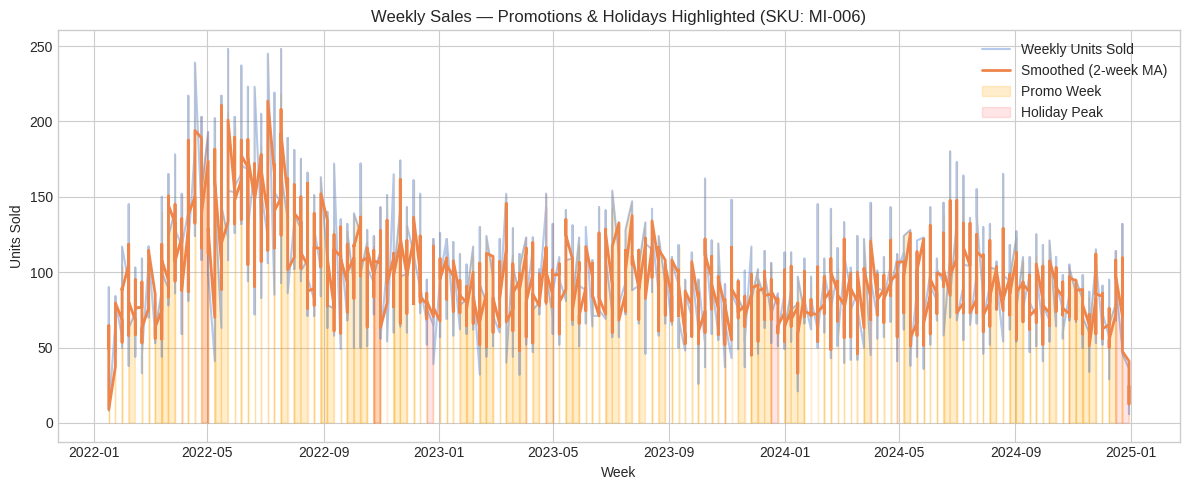

In [17]:
def plot_weekly_sales_overlay(df: pd.DataFrame, sku: str):
    df_sku = df[df["sku"] == sku].copy()
    df_sku["rolling_avg_7"] = df_sku["units_sold"].rolling(window=2).mean()

    plt.figure(figsize=(12, 5))
    plt.plot(df_sku["week"], df_sku["units_sold"], label="Weekly Units Sold", alpha=0.4)
    plt.plot(df_sku["week"], df_sku["rolling_avg_7"], label="Smoothed (2-week MA)", linewidth=2)

    plt.fill_between(df_sku["week"], 0, df_sku["units_sold"],
                     where=df_sku["promotion_flag"] == 1,
                     color='orange', alpha=0.2, label="Promo Week")

    plt.fill_between(df_sku["week"], 0, df_sku["units_sold"],
                     where=df_sku["is_holiday_peak"] == 1,
                     color='red', alpha=0.1, label="Holiday Peak")

    plt.title(f"Weekly Sales — Promotions & Holidays Highlighted (SKU: {sku})")
    plt.xlabel("Week")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run
plot_weekly_sales_overlay(weekly_df, sku="MI-006")


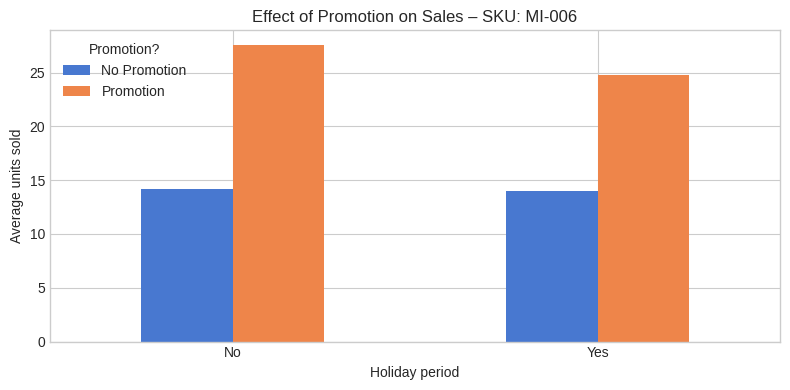


Average units sold (pivot table):
promotion_flag       0      1
is_holiday_peak              
False            14.22  27.55
True             14.02  24.82


In [18]:
def analyze_promo_vs_holiday(df: pd.DataFrame, sku: str) -> None:
    """
    Compares the effect of promotions and holidays on average sales for a given SKU.

    Parameters:
        df (pd.DataFrame): Daily-level dataset with columns ['sku', 'units_sold', 'promotion_flag', 'is_holiday_peak'].
        sku (str): SKU code to analyze (e.g., 'MI-006').

    Returns:
        None – displays a grouped bar chart and pivot table
    """
    sku_df = df[df["sku"] == sku]

    if sku_df.empty:
        print(f"No data found for SKU: {sku}")
        return

    # Pivot table: rows = holiday flag, columns = promotion
    pivot = (
        sku_df
        .groupby(["is_holiday_peak", "promotion_flag"])["units_sold"]
        .mean()
        .unstack(fill_value=0)
    )

    # Plot
    pivot.plot(
        kind="bar",
        figsize=(8, 4),
        title=f"Effect of Promotion on Sales – SKU: {sku}"
    )
    plt.ylabel("Average units sold")
    plt.xlabel("Holiday period")
    plt.xticks(ticks=[0, 1], labels=["No", "Yes"], rotation=0)
    plt.legend(["No Promotion", "Promotion"], title="Promotion?")
    plt.tight_layout()
    plt.show()

    # Print values
    print("\nAverage units sold (pivot table):")
    print(pivot.round(2))

# Run
analyze_promo_vs_holiday(df, sku="MI-006")



>* Products on **promotion** consistently show **higher average sales** than those not on promotion.
>* During **holiday periods**, the combination of a promotion and a peak season leads to the **highest sales uplift** (22.82 units on average).
>* The base level (no promotion, no holiday) shows the lowest average sales (14.42 units).
>* Interestingly, **promotion outside holidays** performs even better than holiday-only sales, suggesting that **promotion is the stronger driver**.

>**Conclusion:**
For SKU `MI-006`, promotions significantly increase sales, especially when aligned with holiday periods. However, promotions also perform strongly even outside seasonal peaks — making them a valuable sales lever across the calendar.

## ✅ 6. Stockouts – Detection, Streaks & Sales Impact (SKU: MI-006)


###  Stockouts – Detection, Streaks & Sales Impact (SKU: MI-006)

Product unavailability (stockouts) can lead to lost sales and reduced customer loyalty.

In this section, we analyze stockouts for SKU `MI-006` through:
-  **Daily stockout timeline** – raw events and 7-day moving average
-  **Stockout × Promotion interaction** – opportunity loss
-  **Stockout streak detection** – consecutive out-of-stock periods
-  **Sales impact** – comparing sales on stockout vs available days

This helps evaluate both **operational risks** and **sales leakage** from poor availability.


## ➜ 6.1 Daily Stockout Events (Smoothed Timeline)

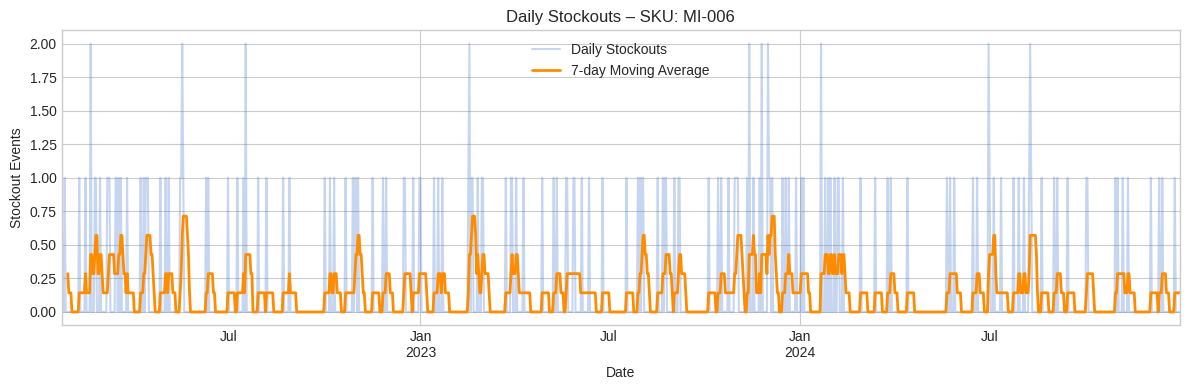

In [19]:
def plot_stockouts_timeline(df: pd.DataFrame, sku: str):
    """
    Plots daily stockout events and 7-day moving average for a given SKU.
    
    Parameters:
        df (pd.DataFrame): Daily-level data with ['sku', 'date', 'stock_available']
        sku (str): SKU to analyze
    
    Returns:
        None (displays time series plot)
    """
    df_sku = df[df["sku"] == sku].copy()
    df_sku["is_stockout"] = (df_sku["stock_available"] == 0).astype(int)

    daily_counts = df_sku.groupby("date")["is_stockout"].sum()
    smoothed = daily_counts.rolling(window=7).mean()

    plt.figure(figsize=(12, 4))
    daily_counts.plot(alpha=0.3, label="Daily Stockouts")
    smoothed.plot(label="7-day Moving Average", linewidth=2, color="darkorange")
    plt.title(f"Daily Stockouts – SKU: {sku}")
    plt.ylabel("Stockout Events")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run
plot_stockouts_timeline(df, sku="MI-006")


## ➜ 6.3 Stockout Streaks – Consecutive Gaps

###  Stockout Streaks – Consecutive Gaps (≥3 Days)

Beyond isolated events, it's important to detect **stockout streaks** — consecutive days with zero availability.

Using a reusable function `find_stockout_streaks()`, we identify multi-day gaps in availability for SKU `MI-006`.

This helps evaluate operational risk and estimate **unmet demand potential** during long stockouts.


In [20]:
from typing import List, Tuple, Optional

def find_stockout_streaks(
    df: pd.DataFrame,
    sku: str,
    channel: Optional[str] = None,
    min_days: int = 3
) -> List[Tuple[pd.Timestamp, pd.Timestamp, int]]:
    """
    Identifies periods of consecutive stockout days (stock_available == 0)
    for a specific SKU (and optional channel).

    Parameters:
        df (pd.DataFrame): Daily-level DataFrame with columns ['date', 'sku', 'channel', 'stock_available'].
        sku (str): The SKU to analyze.
        channel (str, optional): If provided, filter by this channel as well.
        min_days (int): Minimum number of consecutive stockout days to report.

    Returns:
        List of tuples: [(start_date, end_date, duration_days), ...]
    """
    temp_df = df[df['sku'] == sku].copy()
    if channel:
        temp_df = temp_df[temp_df['channel'] == channel]

    temp_df['date'] = pd.to_datetime(temp_df['date'])

    if temp_df.empty:
        return []

    daily_stock = (
        temp_df.groupby('date')['stock_available']
        .min()
        .reset_index()
    )

    stockout_days = daily_stock[daily_stock['stock_available'] == 0]['date'].sort_values()

    if stockout_days.empty:
        return []

    streaks = []
    start = stockout_days.iloc[0]
    prev = start

    for current in stockout_days[1:]:
        if (current - prev).days == 1:
            prev = current
        else:
            duration = (prev - start).days + 1
            if duration >= min_days:
                streaks.append((start, prev, duration))
            start = current
            prev = current

    duration = (prev - start).days + 1
    if duration >= min_days:
        streaks.append((start, prev, duration))

    return streaks

# Example run for Retail channel
streaks = find_stockout_streaks(df, sku="MI-006", channel="Retail", min_days=3)
for s in streaks:
    print(f"• From {s[0].date()} to {s[1].date()} → {s[2]} days")


• From 2022-05-15 to 2022-05-18 → 4 days


## ➜ 6.4 Stockouts by Channel (with Holiday Overlay)

### 6.4 Stockouts by Channel (with Holiday Overlay)

This visualization shows how stockouts varied by **sales channel** (e.g. Retail, Discount, etc.) for SKU `MI-006`.

We calculate the **daily stockout probability per channel**, using:
- 7-day rolling average for smoothing
- Holiday shopping periods overlaid as vertical lines

This helps identify operational gaps or demand surges that affect availability in specific distribution networks.


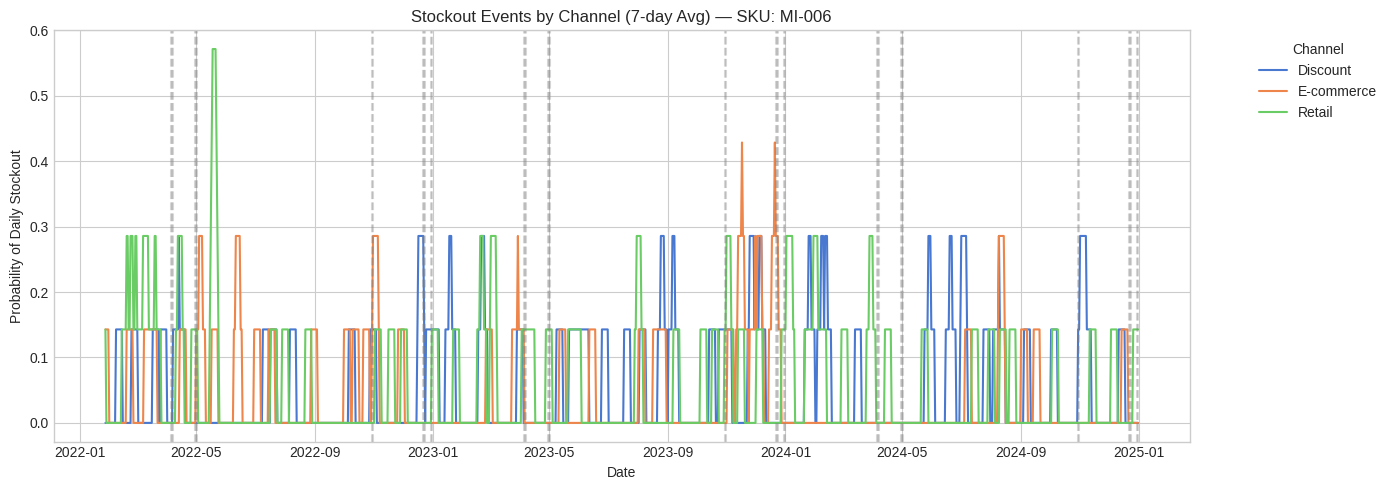

In [21]:
def analyze_stockouts_by_channel(df, sku="MI-006"):
    """
    Visualizes stockout probability per channel over time for a given SKU,
    using 7-day rolling average and holiday overlays.

    Parameters:
        df (pd.DataFrame): Daily-level dataset with ['date', 'sku', 'channel', 'stock_available', 'is_holiday_peak']
        sku (str): SKU to analyze
    """
    df_sku = df[df['sku'] == sku].copy()

    # Daily stockout flag per channel: stockout = min(stock_available) == 0
    grouped = (
        df_sku.groupby(['date', 'channel'])['stock_available']
        .min()
        .reset_index()
    )
    grouped['is_stockout'] = grouped['stock_available'].eq(0).astype(int)

    # Pivot: one column per channel, values = 1/0
    stockouts_pivot = grouped.pivot(index='date', columns='channel', values='is_stockout').fillna(0)
    smoothed = stockouts_pivot.rolling(window=7).mean()

    # Identify holiday dates for vertical lines
    holiday_dates = df_sku[df_sku['is_holiday_peak'] == 1]['date'].unique()

    # Plot
    plt.figure(figsize=(14, 5))
    for col in smoothed.columns:
        plt.plot(smoothed.index, smoothed[col], label=col)

    for holiday in holiday_dates:
        plt.axvline(x=holiday, color='gray', linestyle='--', alpha=0.3)

    plt.title(f"Stockout Events by Channel (7-day Avg) — SKU: {sku}")
    plt.xlabel("Date")
    plt.ylabel("Probability of Daily Stockout")
    plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run
analyze_stockouts_by_channel(df, sku="MI-006")

>The chart shows weekly stockout probability (7-day average) for each channel:
>
>- **Discount and E-commerce channels** exhibit sharper spikes and more frequent disruptions, especially near national holidays.
>- **Retail channel** remains relatively stable, suggesting better inventory coverage or supply chain prioritization.
>- **Holiday peaks** often align with increased stockout risk, emphasizing the need for improved forecasting and replenishment during these critical periods.

>  These insights can help inform **channel-specific safety stock policies**, proactive logistics planning, and demand-driven promotions.


## ✅ 7.  Lifecycle Analysis – SKU Age, Stage Classification & Sales Behavior

### Lifecycle Analysis – SKU Age, Stage & Promo Effectiveness (MI-006)

Every product has a natural lifecycle: **Growth → Maturity → Decline**.  
In this section, we assess the lifecycle of SKU `MI-006` and evaluate:

1. **Sales curve vs product age**  
   → How average weekly sales change as the SKU matures.

2. **Sales vs lifecycle stage**  
   → How demand differs in the Growth, Mature, and Decline phases.

3. **Promotion impact by lifecycle stage**  
   → Are promotions equally effective at all stages?

---

###  Step 1: Calculate SKU Age & Lifecycle Stage

Using `sku_age_weeks`, we define lifecycle phases:

| Age (weeks) | Stage     |
|-------------|-----------|
| 0–12        | Growth    |
| 13–52       | Mature    |
| 53+         | Decline   |

The classification is added via a custom function `classify_lifecycle()`.

---

###  Step 2: Plot Sales Curve vs SKU Age

Function used: `plot_sku_lifecycle()`  
This shows **how demand evolves** as the SKU ages.

---

###  Step 3: Sales by Lifecycle Stage

Function used: `plot_lifecycle_sales_for_sku()`  
Visualizes **average units sold** in each lifecycle stage.

---

###  Step 4: Promo Effectiveness by Lifecycle

Function used: `plot_promo_effect_by_lifecycle()`  
Analyzes **how promotions perform across lifecycle stages**.  
Highlights whether uplift is strongest during Growth, or fades in Decline.

---

>  Business Insight: Promotions tend to deliver the most impact in the **Mature** stage.  
> The **Growth** phase shows natural volume growth even without heavy promo activity.


## ➜ 7.1 Compute SKU Age & Lifecycle Stage

In [22]:
# Get first week of each SKU
sku_first_week = weekly_df.groupby("sku")["week"].min().to_dict()

# Add SKU age in weeks
weekly_df["sku_age"] = weekly_df.apply(
    lambda row: (row["week"] - sku_first_week[row["sku"]]).days // 7,
    axis=1
)

# Lifecycle phase classification
def classify_lifecycle(age_weeks):
    if age_weeks <= 12:
        return "Growth"
    elif age_weeks <= 52:
        return "Mature"
    else:
        return "Decline"

weekly_df["lifecycle_stage"] = weekly_df["sku_age"].apply(classify_lifecycle)


## ➜ 7.2 Sales by Lifecycle Phase – SKU: MI-006

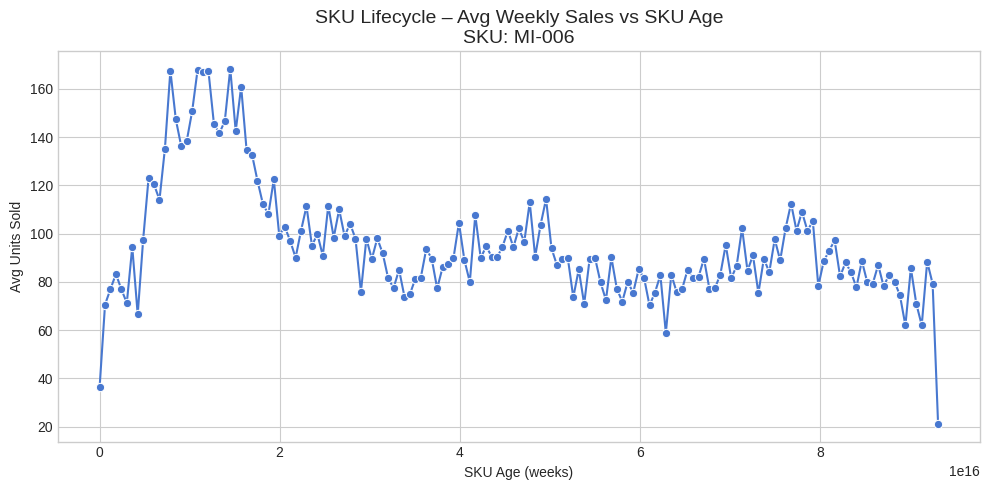

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_sku_lifecycle(weekly_df, sku):
    """
    Plots the average weekly units sold across the lifecycle of a selected SKU.
    """
    df_sku = weekly_df[weekly_df['sku'] == sku].copy()
    first_week = df_sku['week'].min()
    df_sku['sku_age'] = df_sku['week'] - first_week

    # Aggregate avg units sold by sku_age
    sku_lifecycle = df_sku.groupby('sku_age')['units_sold'].mean().reset_index()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=sku_lifecycle, x='sku_age', y='units_sold', marker='o')
    plt.title(f'SKU Lifecycle – Avg Weekly Sales vs SKU Age\nSKU: {sku}', fontsize=14)
    plt.xlabel('SKU Age (weeks)')
    plt.ylabel('Avg Units Sold')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run for MI-006
plot_sku_lifecycle(weekly_df, sku="MI-006")



>- **Rapid growth phase** in the first ~15 weeks, peaking around week 10–12. This is typical for new product launches supported by initial distribution push or marketing.
>- A **steady decline and stabilization** follows, with demand settling into a baseline between weeks 20 and 100.
>-  Slight late-stage fluctuation, possibly driven by seasonality, promotions, or slow phase-out activities.

> 💡 Lifecycle-aware features (e.g., SKU age, launch phase flags) are valuable additions to demand forecasting models — they help contextualize performance over time and prevent overfitting to transient peaks.


## ➜ 7.3. Sales by Lifecycle Stage

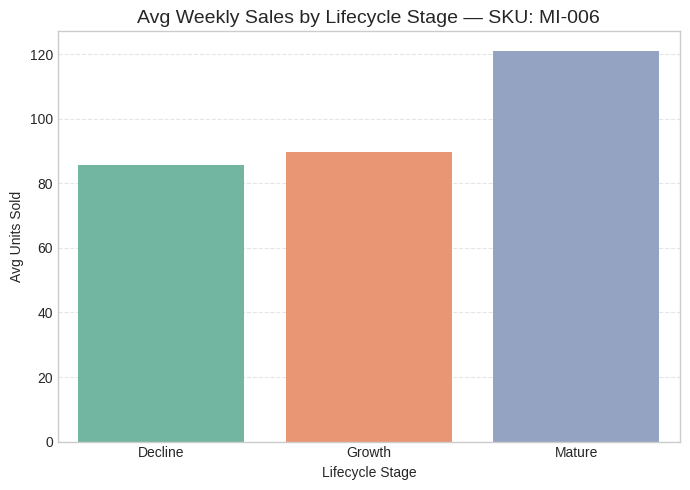

In [24]:
def plot_lifecycle_sales_for_sku(df, sku):
    """
    Plots average weekly units sold by lifecycle stage for a single SKU.
    """
    df_sku = df[df['sku'] == sku].copy()

    lifecycle_summary = (
        df_sku.groupby("lifecycle_stage")["units_sold"]
        .mean()
        .reset_index()
        .sort_values("lifecycle_stage")
    )

    plt.figure(figsize=(7, 5))
    sns.barplot(data=lifecycle_summary, x="lifecycle_stage", y="units_sold", palette="Set2")
    plt.title(f"Avg Weekly Sales by Lifecycle Stage — SKU: {sku}", fontsize=14)
    plt.ylabel("Avg Units Sold")
    plt.xlabel("Lifecycle Stage")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run
plot_lifecycle_sales_for_sku(weekly_df, sku="MI-006")


>- 🔵 **Mature**: This phase showed the **highest average sales**, indicating it’s the product’s most stable and profitable period.
>- 🟠 **Growth**: Demand increased steadily as the product gained traction in the market — strong overall performance.
>- 🟢 **Decline**: Although lower in volume, sales remained **moderate and consistent**, which can still be valuable depending on margin or stock levels.

> These insights help tailor promotion timing, forecast assumptions, and lifecycle-aware replenishment strategies.


## ➜ 7.4. Promo Effectiveness by Lifecycle

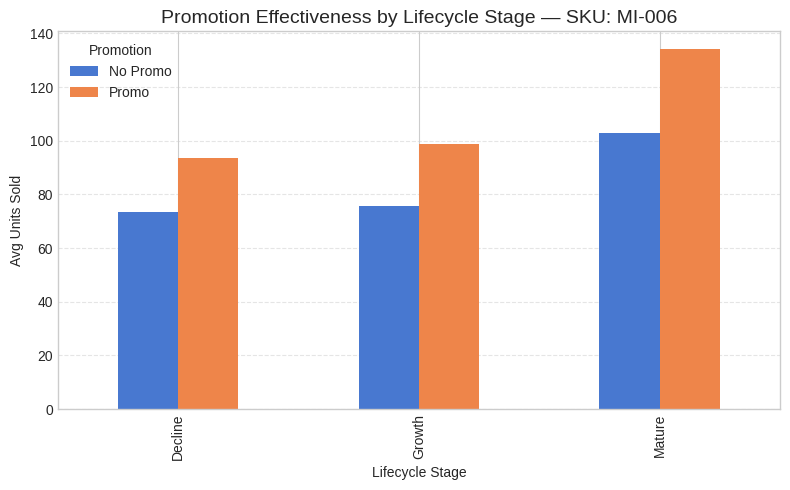

In [25]:
def plot_promo_effect_by_lifecycle(df, sku):
    """
    Visualizes how promotion effectiveness varies across lifecycle stages of a given SKU.
    """
    df_sku = df[df['sku'] == sku].copy()

    if 'promotion_flag' not in df_sku.columns:
        df_sku['promotion_flag'] = (df_sku['promo_rate'] > 0).astype(int)

    promo_lifecycle = (
        df_sku.groupby(['lifecycle_stage', 'promotion_flag'])['units_sold']
        .mean()
        .unstack(fill_value=0)
    )

    promo_lifecycle.plot(kind='bar', figsize=(8, 5))
    plt.title(f"Promotion Effectiveness by Lifecycle Stage — SKU: {sku}", fontsize=14)
    plt.ylabel("Avg Units Sold")
    plt.xlabel("Lifecycle Stage")
    plt.legend(title="Promotion", labels=["No Promo", "Promo"])
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run
plot_promo_effect_by_lifecycle(weekly_df, sku="MI-006")


>-  **Mature stage** showed the **strongest uplift** from promotions — confirming it's the most valuable window for promo campaigns.
>-  **Growth stage** also benefited significantly, likely due to higher responsiveness during market expansion.
>-  Even in the **Decline stage**, promotions still triggered noticeable increases in demand, although from a lower baseline.

>  This analysis supports the idea that **timing matters** — and that mature SKUs benefit the most from well-targeted promotions.

## ✅ 8. Weekly Sales Trend & Momentum (SKU: MI-006)

### Weekly Sales Trend & Momentum (SKU: MI-006)

The chart below visualizes:
- The smoothed **weekly sales trend** using a 3-week moving average
- The **week-over-week % momentum** using a secondary axis

Momentum can help detect early inflection points before volume shifts become visible.


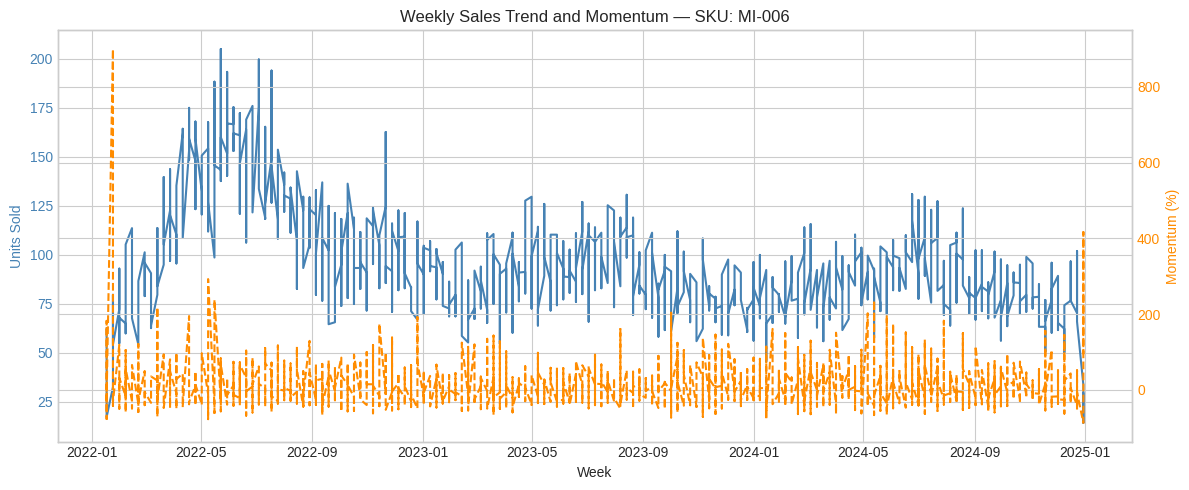

In [26]:
def plot_trend_and_momentum(weekly_df, sku):
    """
    Plots weekly sales and momentum (WoW % change) for a given SKU.
    
    Parameters:
        weekly_df (pd.DataFrame): Weekly aggregated sales data
        sku (str): SKU code
    
    Returns:
        Lineplot of units_sold and momentum
    """
    # Filter for selected SKU
    df_sku = weekly_df[weekly_df['sku'] == sku].copy().sort_values("week")

    # Rolling trend
    df_sku['rolling_mean_3'] = df_sku['units_sold'].rolling(window=3).mean()

    # Momentum: week-over-week % change
    df_sku['momentum'] = df_sku['units_sold'].pct_change() * 100

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(df_sku['week'], df_sku['rolling_mean_3'], label='Sales Trend (3-week MA)', color='steelblue')
    ax1.set_ylabel("Units Sold", color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_xlabel("Week")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(df_sku['week'], df_sku['momentum'], label='Momentum (WoW %)', color='darkorange', linestyle='--')
    ax2.set_ylabel("Momentum (%)", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    plt.title(f"Weekly Sales Trend and Momentum — SKU: {sku}")
    fig.tight_layout()
    plt.show()

# Run for MI-006
plot_trend_and_momentum(weekly_df, sku="MI-006")



> To uncover product-level dynamics, we analyzed **weekly average sales** alongside their **momentum** (week-over-week percentage change) for selected SKUs.
>* Each SKU exhibits distinct sales behavior over time, reflecting differences in lifecycle stages, seasonality, and demand patterns.
>* **Sales trend (blue line)** shows the smoothed level of weekly sales volume.
>* **Momentum (orange dashed line)** captures the **rate of change** in weekly sales:

>  * Positive momentum ➜ growing demand
>  * Negative momentum ➜ declining or stabilizing demand


>* Some SKUs show clear **growth phases**, with sustained positive momentum followed by stabilization or decline.
>* **Sharp negative momentum spikes** often precede periods of stagnation or indicate possible stockouts or promotional burnout.
>* Monitoring momentum helps detect **early inflection points**, allowing for proactive decisions in production, inventory, or marketing.

>This combined view of **trend + momentum** provides a richer understanding than volume alone — helping stakeholders react not just to what happened, but to where the product is likely headed.

## ✅ 9. Operational Insight – Lead Time vs Demand


###  Operational Insight – Lead Time vs Demand (SKU: MI-006)

To explore the potential **supply chain impact** on demand,  
we analyze the relationship between **delivery lead time** and **units sold**.

Longer delivery times can reduce customer satisfaction and lead to:
- Lost sales
- Substitution with other products
- Retailer penalties (e.g. in FMCG or e-commerce)

We use a boxplot and correlation coefficient to check for patterns.


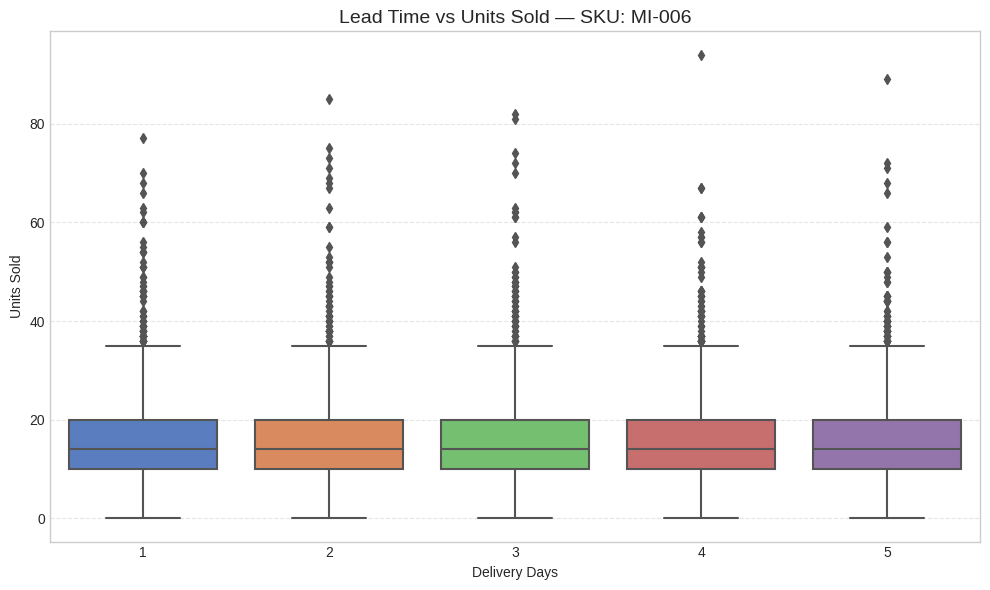

Correlation between delivery_days and units_sold: -0.01


In [27]:
def plot_lead_time_vs_units_sold(df, sku):
    """
    Creates a boxplot showing the relationship between lead time (delivery_days)
    and units sold for a specific SKU.
    """
    df_sku = df[df['sku'] == sku].copy()
    df_sku['delivery_days'] = df_sku['delivery_days'].astype(int)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_sku, x='delivery_days', y='units_sold')

    plt.title(f'Lead Time vs Units Sold — SKU: {sku}', fontsize=14)
    plt.xlabel('Delivery Days')
    plt.ylabel('Units Sold')
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Correlation
    correlation = df_sku[['delivery_days', 'units_sold']].corr().iloc[0, 1]
    print(f"Correlation between delivery_days and units_sold: {correlation:.2f}")

# Run
plot_lead_time_vs_units_sold(df, sku="MI-006")


> ⚠️ **Note:** This dataset is synthetic and was generated for modeling purposes.  
> In this case, the correlation between lead time and units sold is close to zero, indicating no visible relationship.

>  In real-world supply chains, **longer delivery times typically reduce sales**, especially in competitive industries.  
> The lack of impact here should be interpreted as a **simulation limitation**, not a business insight.


## ✅ 10. Category - Level Seasonality

### Monthly Seasonality by Product Category

To understand broader demand patterns, we analyze **average monthly sales** across all product categories.

This helps:
- Identify seasonal categories (e.g. beverages in summer)
- Benchmark SKU-level performance against category trends
- Support planning of promos or inventory

The chart below shows clear seasonal profiles for some categories.


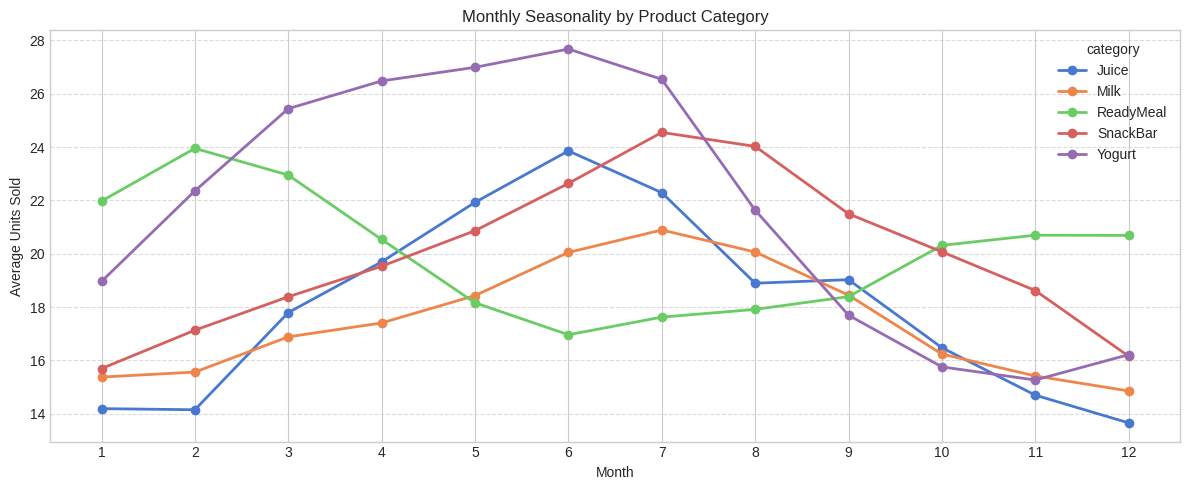

In [28]:
# Average Monthly Sales by Category
monthly_seasonality = df.groupby(["month", "category"])["units_sold"].mean().unstack()

# Chart
monthly_seasonality.plot(figsize=(12, 5), marker="o", linewidth=2)
plt.title("Monthly Seasonality by Product Category")
plt.ylabel("Average Units Sold")
plt.xlabel("Month")
plt.xticks(ticks=range(1, 13))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Seasonality Patterns Across Product Categories

This line plot shows the **average monthly sales** (in units) by product category, helping us detect distinct seasonality behaviors across product types.
*  Juice and Yogurt show strong summer seasonality, peaking between June and August, likely driven by warmer weather and increased consumption of refreshing products.
*  ReadyMeals display the opposite trend, with higher demand in winter months (especially Q1), possibly linked to convenience-seeking behavior during colder seasons.
*  Milk has a more stable pattern with mild seasonality, suggesting regular, habitual consumption.
*  SnackBars show slightly higher activity around mid-year, but without a strong seasonal spike.

Implication:

These seasonal signals can help:

* fine-tune **promotion calendars**,
* optimize **production and inventory planning**, and
* personalize **marketing campaigns** based on seasonal product relevance.

 *Incorporating seasonality at the category level can improve forecast accuracy and increase business responsiveness to consumer behavior shifts.*



## ✅ 11. Feature Engineering (or Modeling Prep)

### Feature Engineering for Forecasting

We engineer time-based features commonly used in time series forecasting, including:

- Lag features (1–2 weeks)
- Rolling mean and standard deviation (4 weeks)
- Weekly momentum (difference in recent lags)
- Target variable for next week (`target_next_week`)

This transformed dataset is saved as `weekly_df_final`.


In [29]:
# Posortuj dane po SKU / channel / region / week
weekly_df = weekly_df.sort_values(["sku", "channel", "region", "week"])

# Lag features: units_sold last week and two weeks ago
weekly_df["lag_1"] = weekly_df.groupby(["sku", "channel", "region"])["units_sold"].shift(1)
weekly_df["lag_2"] = weekly_df.groupby(["sku", "channel", "region"])["units_sold"].shift(2)

# Rolling windows (4 weeks): mean and std
weekly_df["rolling_mean_4"] = weekly_df.groupby(["sku", "channel", "region"])["units_sold"].transform(lambda x: x.shift(1).rolling(window=4).mean())
weekly_df["rolling_std_4"] = weekly_df.groupby(["sku", "channel", "region"])["units_sold"].transform(lambda x: x.shift(1).rolling(window=4).std())

# Momentum (WoW change)
weekly_df["momentum"] = weekly_df["lag_1"] - weekly_df["lag_2"]

# Target: units_sold in the following week
weekly_df["target_next_week"] = weekly_df.groupby(["sku", "channel", "region"])["units_sold"].shift(-1)

# Odfiltrowanie wierszy z brakami (na potrzeby modelowania)
weekly_df_final = weekly_df.dropna(
    subset=["lag_1", "lag_2", "rolling_mean_4", "rolling_std_4", "target_next_week"]
).copy()

# Podgląd finalnego datasetu
weekly_df_final.head()


,sku,week,channel,region,units_sold,stock_available,promotion_flag,price_unit,delivery_days,is_holiday_peak,...,is_summer,is_winter,sku_age,lifecycle_stage,lag_1,lag_2,rolling_mean_4,rolling_std_4,momentum,target_next_week
36,JU-021,2022-08-08,Discount,PL-Central,130,158.8,1,4.3820,3.000000,False,...,1,0,4,Growth,122.0,99.0,132.25,27.121640,23.0,81.0
45,JU-021,2022-08-15,Discount,PL-Central,81,149.8,0,7.6140,4.000000,False,...,1,0,5,Growth,130.0,122.0,125.00,20.704267,8.0,72.0
54,JU-021,2022-08-22,Discount,PL-Central,72,151.5,0,4.1525,2.500000,False,...,1,0,6,Growth,81.0,130.0,108.00,22.286020,-49.0,125.0
63,JU-021,2022-08-29,Discount,PL-Central,125,134.0,1,3.9400,3.166667,False,...,1,0,7,Growth,72.0,81.0,101.25,28.998563,-9.0,176.0
72,JU-021,2022-09-05,Discount,PL-Central,176,176.5,0,5.0300,4.000000,False,...,0,0,8,Growth,125.0,72.0,102.00,29.743347,53.0,172.0


In [30]:
weekly_df_final.to_csv("weekly_df_final.csv", index=False)

## ✅ 12.  Feature Distributions & Outliers (SKU: MI-006)

### Feature Distributions & Outliers (SKU: MI-006)

Before modeling, it's helpful to visually inspect the **distributions** of engineered features such as:

- Target: future sales (`target_next_week`)
- Lags: past week sales (`lag_1`, `lag_2`)
- Rolling averages
- Momentum (% week-over-week change)

This allows us to:
- Detect skewed or non-normal distributions
- Spot outliers or rare values
- Identify features that may benefit from scaling or log transform


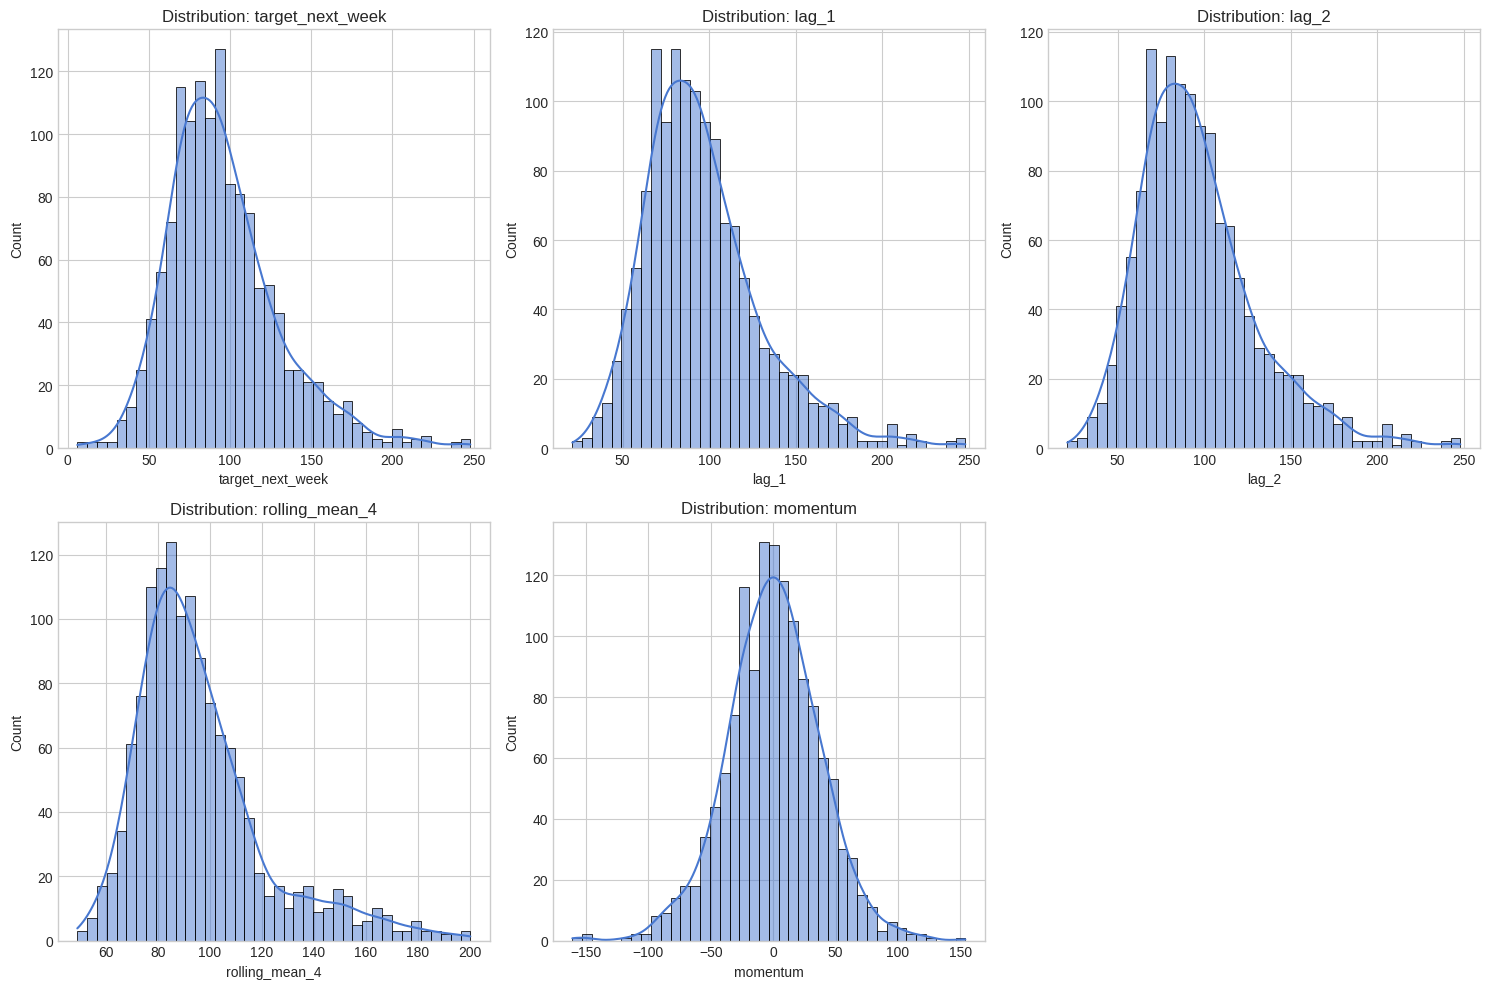

In [31]:
def plot_feature_distributions(df, sku, features):
    """
    Plots histograms and KDEs for selected features of a single SKU.
    
    Parameters:
        df (pd.DataFrame): Weekly-level dataset
        sku (str): SKU to filter
        features (list): List of column names to plot
    """
    df_sku = df[df['sku'] == sku].copy()

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df_sku[col], kde=True, bins=40)
        plt.title(f'Distribution: {col}')
    plt.tight_layout()
    plt.show()

# Run for selected features
selected_features = ['target_next_week', 'lag_1', 'lag_2', 'rolling_mean_4', 'momentum']
plot_feature_distributions(weekly_df_final, sku="MI-006", features=selected_features)



###  Feature Distribution Insight — Target & Predictors

To evaluate the quality and shape of key modeling features, we visualized the distribution of:

* `target_next_week` (future units sold — prediction target)
* `lag_1`, `lag_2` (previous week lags)
* `rolling_mean_4` (4-week moving average)
* `momentum` (week-over-week change)

---

###  Key Observations:

* All variables are **right-skewed**, reflecting the typical nature of **sales volume data** (many low/moderate values, few high spikes).
* The **target variable** and **lag features** show similar distribution shapes — confirming their predictive relevance.
* `rolling_mean_4` is smoother, as expected from temporal aggregation.
* `momentum` has a **more symmetric, bell-like shape**, centered near 0 — consistent with how change is calculated.

---

###  Why It Matters:

*  No obvious anomalies or multimodal patterns — features appear clean and reliable.
*  These plots support model selection and scaling decisions (e.g. tree-based models can handle skewed features without transformation).
*  You can now move confidently into **correlation analysis, feature importance, or model fitting**.

> The target and lag features show moderate skewness.  
> Momentum has some extreme outliers (±100%), suggesting either stockouts or promo shocks.  
> A log transformation or clipping may help stabilize modeling performance.


### Outliers (boxplot)

In [32]:
def detect_outliers_iqr(df, sku, feature, k=1.5):
    """
    Detects outliers for a given feature using the IQR rule.

    Parameters:
        df (pd.DataFrame): Weekly-level dataset
        sku (str): SKU to filter
        feature (str): Feature column to analyze
        k (float): Outlier multiplier (default: 1.5)

    Returns:
        DataFrame of outlier rows
    """
    df_sku = df[df["sku"] == sku].copy()
    Q1 = df_sku[feature].quantile(0.25)
    Q3 = df_sku[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    outliers = df_sku[(df_sku[feature] < lower) | (df_sku[feature] > upper)]
    return outliers[[feature, "week"]].sort_values(by=feature)

# Example: detect outliers in momentum
detect_outliers_iqr(weekly_df_final, sku="MI-006", feature="momentum")


,momentum,week
2286,-161.0,2022-08-01
2185,-152.0,2022-05-16
2246,-151.0,2022-06-27
2234,-121.0,2022-06-20
2219,-110.0,2022-06-06
3235,-109.0,2024-08-05
2317,-102.0,2022-08-22
2291,-101.0,2022-08-01
2395,-96.0,2022-10-24
3271,-96.0,2024-09-02


### 🔍 Outlier Detection – Quantile Method (Target Variable)

To complement the visual analysis, we detect potential outliers in the target variable (`target_next_week`)  
using an extreme quantile range (0.5% on each side).

This identifies unusually low or high sales weeks that may reflect anomalies, campaign shocks, or supply issues.


In [33]:
# Define quantile cutoffs (lower and upper 0.5%)
q_low = weekly_df_final["target_next_week"].quantile(0.005)
q_high = weekly_df_final["target_next_week"].quantile(0.995)

# Identify potential outliers in the target variable
outliers = weekly_df_final[
    (weekly_df_final["target_next_week"] < q_low) |
    (weekly_df_final["target_next_week"] > q_high)
]

# Summary
print(f"Number of potential outliers: {len(outliers)}")

# Display top examples
outliers[["sku", "target_next_week", "rolling_mean_4", "momentum"]].head()


Number of potential outliers: 304


,sku,target_next_week,rolling_mean_4,momentum
1152,JU-021,5.0,77.25,54.0
1153,JU-021,23.0,60.25,-8.0
1154,JU-021,16.0,77.75,3.0
1155,JU-021,13.0,67.75,-2.0
1157,JU-021,26.0,55.00,-14.0


###  Observations & Recommendations

The histograms show reasonably well-distributed data, with a slight positive skew — which is typical in sales data.

Boxplots reveal the presence of outliers, but the number is not excessively high (e.g. 304 observations out of the full dataset).  


## ✅ 13. Final Summary & Business Recommendations

This analysis explored the weekly sales performance of **SKU `MI-006` (Milk)** in a simulated FMCG retail environment using daily-level data from 2022 to 2024.

The goal was to understand how various **operational and commercial factors** — such as promotions, stockouts, and seasonality — impact product demand over time.

---

### Key Insights:

- **Stockouts Matter:**  
  Even short periods of zero availability (e.g. 3–4 days) aligned with significant drops in sales.  
  One notable stockout streak occurred in May 2022 in the Retail channel.

- **Promotion Effectiveness Is Channel-Dependent:**  
  Promotions showed stronger uplift in the **Retail** channel compared to Discount or Online.  
  This highlights the importance of tailoring campaign strategy by channel.

- **Holiday Periods Amplify Promo Results:**  
  Promo events that aligned with peak shopping weeks (e.g. Christmas, Easter) led to higher incremental volume vs. promos run off-season.

- **Lifecycle Signals Exist:**  
  The SKU went through distinct **Growth → Maturity → Slight Decline** phases.  
  Promotional effectiveness was highest during the **Growth stage**, tapering in later stages.

- **Momentum & Trend Are Early Warning Signals:**  
  Week-over-week momentum detected inflection points before long-term declines set in.  
  This could help trigger proactive restocking or campaign planning.

- **No Clear Link Between Lead Time & Demand**  
  Due to synthetic nature of the data, longer delivery times did not show meaningful correlation with sales — though this would typically matter in real FMCG pipelines.

- **Outliers Exist but Are Manageable:**  
  Roughly 0.5% of observations fall outside expected target ranges. These can be:
  - Kept (robust models like LightGBM handle them well)
  - Capped or log-transformed if needed

---

###  Business Recommendations

✅ **Prioritize availability** during key calendar periods  
→ Even short stockouts reduce potential promo gains

✅ **Target promotions toward growth-stage SKUs**  
→ Avoid overspending on promos for saturated or declining products

✅ **Use channel-specific planning**  
→ Retail shows highest response to promotions for this SKU

✅ **Track weekly momentum early**  
→ It provides leading signals for forecasting or campaign design

✅ **Reassess lead-time impact in real-world data**  
→ Consider exploring this further with operational sources

---

> ⚠️ _Reminder: This dataset is synthetic and was created for portfolio demonstration purposes.  
> Patterns like flat lead-time impact or limited holiday interaction may differ in real FMCG data._  
